# Chroma Vector Database Tutorial

빠른 이미지 검색을 위한 벡터 데이터베이스 튜토리얼

> 유튜브 [빵형의 개발도상국](https://www.youtube.com/@bbanghyong)

In [1]:
!pip install -q chromadb transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 402.8/402.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 93.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 108.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 125.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.5 MB/s eta 0:00:00
     ━━━━

## Dataset

Food-11 데이터셋 중 evaluation 데이터 10장씩

https://www.kaggle.com/datasets/trolukovich/food11-image-dataset

In [2]:
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -q Food-11.zip

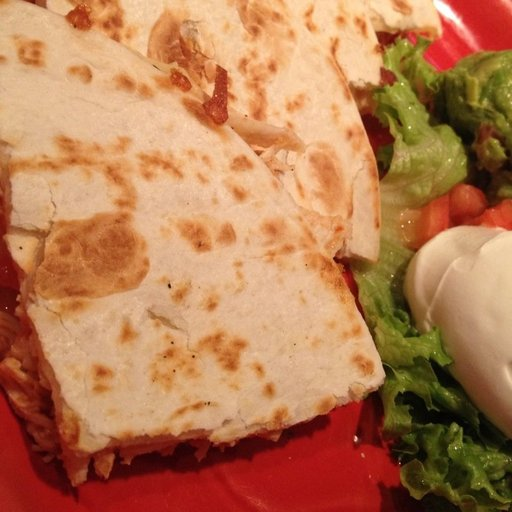

In [ ]:
from PIL import Image

img = Image.open("test/Bread/0.jpg")

img

## Image Vectorizer 모델 로드

https://huggingface.co/facebook/dino-vits16

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16')
model = ViTModel.from_pretrained('facebook/dino-vits16').to("cuda")

print("Models loaded!")

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Models loaded!


## 임베딩

In [ ]:
img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
outputs = model(**img_tensor)

embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

embedding

array([-0.4678626 ,  0.4683599 , -0.9984876 ,  0.9995814 ,  0.310693  ,
        0.9716406 ,  0.9612691 ,  0.7365191 ,  0.99738455, -0.92708486,
        0.5605221 ,  0.9917714 ,  0.9421079 , -0.96331286,  0.7526174 ,
       -0.98649585,  0.9738568 , -0.5759692 , -0.980308  , -0.5356691 ,
        0.6579461 ,  0.9753116 , -0.6112621 , -0.9940228 , -0.40531933,
        0.9990199 , -0.36555856,  0.96850646, -0.9160518 , -0.5468993 ,
       -0.44172442, -0.9901558 ,  0.9160812 ,  0.9551466 ,  0.5097936 ,
       -0.16309017,  0.988275  , -0.53135496, -0.8993496 ,  0.97942495,
       -0.9892802 , -0.9908753 ,  0.65556324,  0.9728153 ,  0.5093087 ,
        0.5133334 , -0.62647116,  0.34532496,  0.9996438 ,  0.88791627,
       -0.3165353 , -0.8445026 , -0.68530405, -0.8496127 ,  0.9943989 ,
       -0.9907043 , -0.68105984,  0.73805106, -0.1603953 ,  0.8821261 ,
        0.89602995,  0.9956023 ,  0.9151364 , -0.99850196, -0.9192457 ,
       -0.3424168 , -0.82643616, -0.95005953,  0.99959373, -0.94

In [ ]:
embedding.shape

(384,)

## Chroma DB 시작

https://www.trychroma.com

In [ ]:
import chromadb

client = chromadb.Client()

collection = client.create_collection("foods")

## 모든 이미지 벡터화

In [ ]:
from glob import glob

img_list = sorted(glob("test/*/*.jpg"))

len(img_list)

110

In [ ]:
from tqdm import tqdm

embeddings = []
metadatas = []
ids = []

for i, img_path in enumerate(tqdm(img_list)):
    img = Image.open(img_path)
    cls = img_path.split("/")[1]

    img_tensor = feature_extractor(images=img, return_tensors="pt").to("cuda")
    outputs = model(**img_tensor)

    embedding = outputs.pooler_output.detach().cpu().numpy().squeeze()

    embeddings.append(embedding)

    metadatas.append({
        "uri": img_path,
        "name": cls
    })

    ids.append(str(i))

print("Done!")

100%|██████████| 110/110 [00:03<00:00, 33.77it/s]

Done!


## 임베딩을 데이터베이스에 저장

In [ ]:
collection.add(
    embeddings=embeddings,
    metadatas=metadatas,
    ids=ids,
)

## Test1

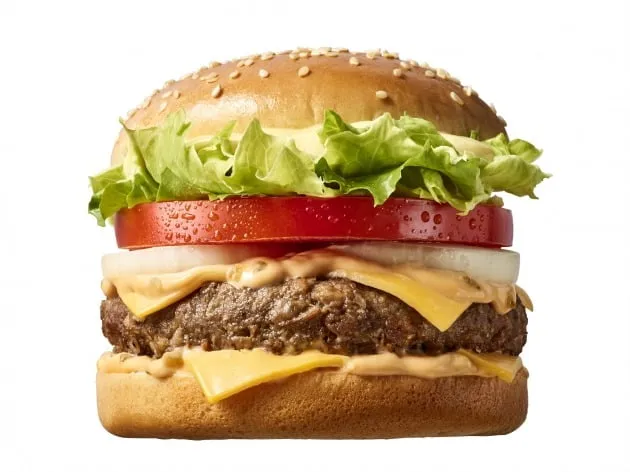

In [ ]:
import requests

test_img = Image.open(requests.get("https://i.imgur.com/yNp6qTS.png", stream=True).raw).convert("RGB")

test_img

In [ ]:
test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
test_outputs = model(**test_img_tensor)

test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()

test_embedding.shape

(384,)

In [ ]:
query_result = collection.query(
    query_embeddings=[test_embedding],
    n_results=3,
)

query_result

ValueError: ignored

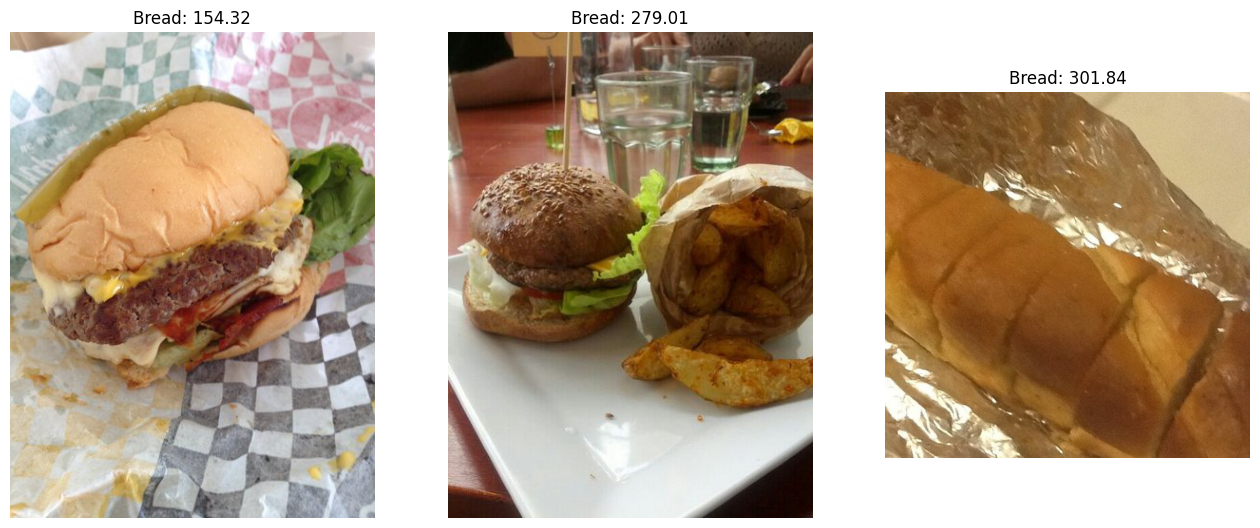

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 10))

for i, metadata in enumerate(query_result["metadatas"][0]):
    distance = query_result["distances"][0][i]

    axes[i].imshow(Image.open(metadata["uri"]))
    axes[i].set_title(f"{metadata['name']}: {distance:.2f}")
    axes[i].axis("off")

## 테스트를 위한 함수화

In [ ]:
def query(img_url, n_results=3):
    test_img = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

    test_img_tensor = feature_extractor(images=test_img, return_tensors="pt").to("cuda")
    test_outputs = model(**test_img_tensor)

    test_embedding = test_outputs.pooler_output.detach().cpu().numpy().squeeze()

    query_result = collection.query(
        query_embeddings=[test_embedding],
        n_results=n_results,
    )

    fig, axes = plt.subplots(1, 4, figsize=(16, 10))

    axes[0].imshow(test_img)
    axes[0].set_title("Query")
    axes[0].axis("off")

    for i, metadata in enumerate(query_result["metadatas"][0]):
        distance = query_result["distances"][0][i]

        axes[i+1].imshow(Image.open(metadata["uri"]))
        axes[i+1].set_title(f"{metadata['name']}: {distance:.2f}")
        axes[i+1].axis("off")

    return query_result

## Test2

{'ids': [['54', '58', '107']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'test/Meat/4.jpg', 'name': 'Meat'},
   {'uri': 'test/Meat/8.jpg', 'name': 'Meat'},
   {'uri': 'test/Vegetable-Fruit/7.jpg', 'name': 'Vegetable-Fruit'}]],
 'distances': [[274.8021240234375, 291.9483947753906, 300.3393859863281]]}

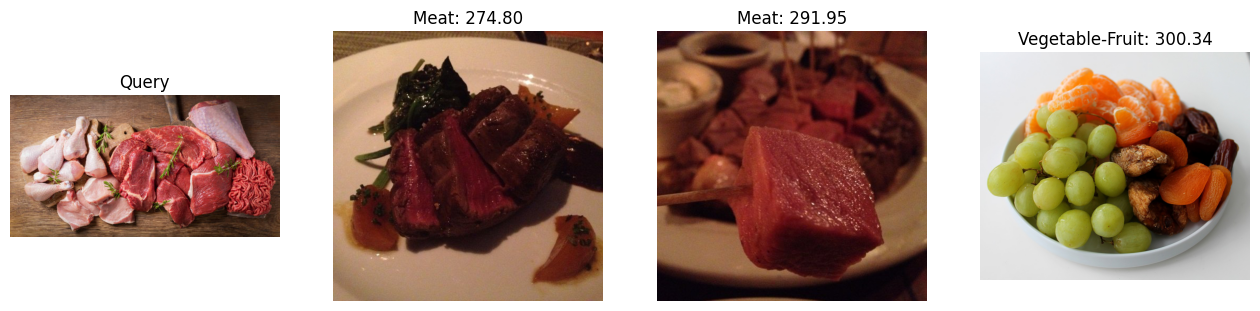

In [ ]:
query("https://i.imgur.com/QCado9g.jpg")

{'ids': [['14', '13', '47']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'test/Dairy product/4.jpg', 'name': 'Dairy product'},
   {'uri': 'test/Dairy product/3.jpg', 'name': 'Dairy product'},
   {'uri': 'test/Fried food/7.jpg', 'name': 'Fried food'}]],
 'distances': [[217.67208862304688, 252.4796600341797, 256.6849060058594]]}

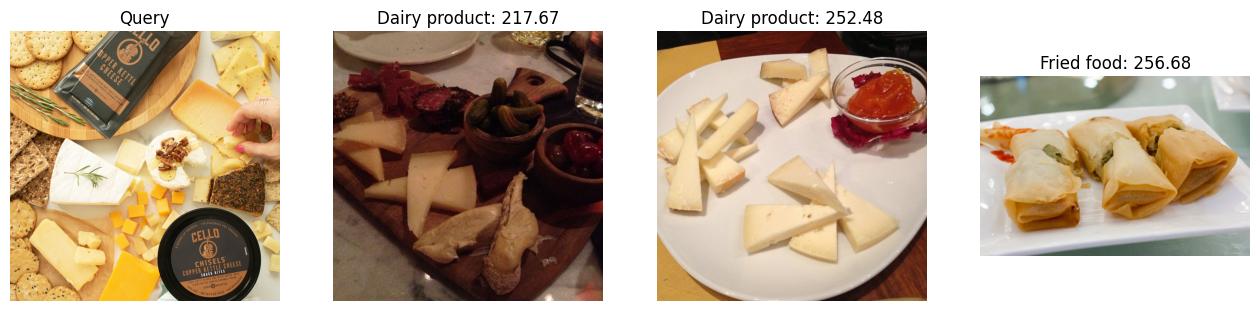

In [ ]:
query("https://i.imgur.com/lf5C0LI.png")

{'ids': [['77', '72', '73']],
 'embeddings': None,
 'documents': [[None, None, None]],
 'metadatas': [[{'uri': 'test/Rice/7.jpg', 'name': 'Rice'},
   {'uri': 'test/Rice/2.jpg', 'name': 'Rice'},
   {'uri': 'test/Rice/3.jpg', 'name': 'Rice'}]],
 'distances': [[236.92507934570312, 249.4188232421875, 249.5189208984375]]}

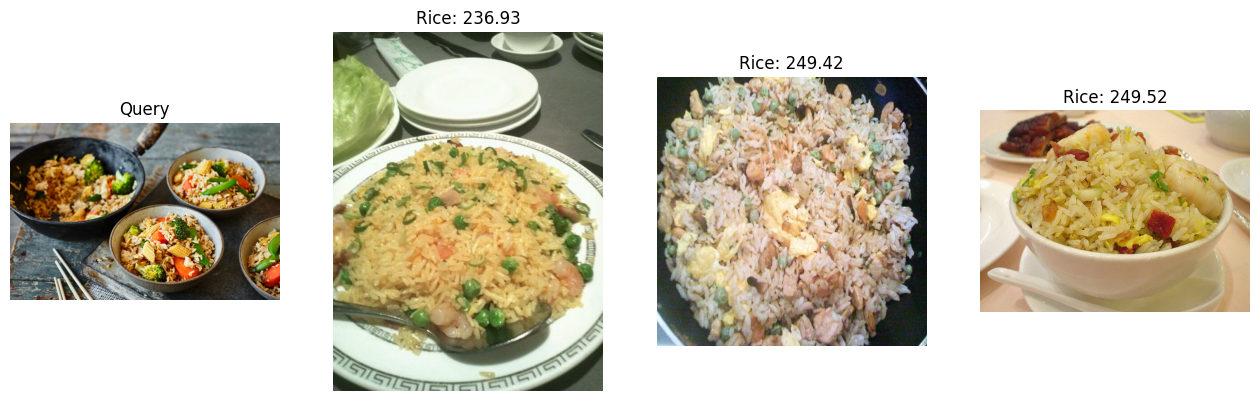

In [ ]:
query("https://i.imgur.com/WlLv0i9.png")